In [1]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from multiprocessing import Pool
import pickle
pd.options.mode.chained_assignment = None 
import copy
from scipy.stats import norm
import random
import pickle

/home/denis/hdd/Gasnikov/env/lib/python3.6/site-packages/graph_tool/draw/cairo_draw.py:1463: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [2]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/home/denis/hdd/Gasnikov/TransportNet/Stable Dynamic & Beckman/model.py'>

In [3]:
import numba
numba.__version__

'0.49.0'

In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

/home/denis/hdd/Gasnikov/env/bin/python3
3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
python 3.6.9
numpy 1.19.1
pandas 1.1.0
graph_tool 2.30 (commit 087aace0, Mon Mar 23 08:58:49 2020 +0000)


# Beckmann model

parameter $\mu = 0.25$

In [7]:
beckmann_save = 'beckmann_results/'
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

In [8]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

In [9]:
epsilon = 10
max_iter = 10000
solvers = ['wda', 'ustm']

In [10]:
result_initial = {}
for solver in solvers:
    solver_kwargs = {'eps_abs': epsilon,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose' : True, 'verbose_step': 4000, 'save_history' : True}
    tic = time.time()
    result_initial[solver] = model.find_equilibrium(solver_name = solver, composite = True, solver_kwargs = solver_kwargs)
    toc = time.time()

Composite optimization...
Weighted dual averages method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 4000
Primal_func_value = 1.28604e+06
Dual_func_value = -1.28602e+06
Duality_gap = 18.1014
Duality_gap / Duality_gap_init = 0.000377636

Result: success
Total iters: 7554
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28602e+06
Duality_gap = 9.99892
Duality_gap / Duality_gap_init = 0.0002086
Oracle elapsed time: 433 sec
Composite optimization...
Universal similar triangles method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Result: success
Total iters: 685
Primal_func_value = 1.28604e+06
Dual_func_value = -1.28603e+06
Duality_gap = 9.96941
Duality_gap / Duality_gap_init = 0.000207985
Oracle elapsed time: 79 sec


In [52]:
def node_roads(graph_table, node):
    return set(graph_table[np.array(graph_table['term_node'] == node) + np.array(graph_table['init_node'] == node)].index)


def edge_neighbours(graph_table, edge_num):
    init_node = graph_table.loc[edge_num]['init_node']
    term_node = graph_table.loc[edge_num]['term_node']
    res = node_roads(graph_table, init_node)
    res.update(node_roads(graph_table, term_node))
    return res

def n_neighbour_edges(graph_table, node, depth):
    neighbours = node_roads(graph_table, node)
    for i in range(depth - 1):
        new_neighbours = neighbours.copy()
        for curr_edge in neighbours:
            new_neighbours.update(edge_neighbours(graph_table, curr_edge))
        neighbours = new_neighbours
    return neighbours


def normal_distribution_noise(node, depth, std_percentage_capacity, std_percentage_flow):
    graph_data_copy = copy.deepcopy(graph_data)
    graph_correspondences_copy = copy.deepcopy(graph_correspondences)
    graph_capacity = graph_data_copy['graph_table']['capacity']
    graph_free_flow_time = graph_data_copy['graph_table']['free_flow_time']

    graph_table = graph_data['graph_table']
    neighbour_edges = n_neighbour_edges(graph_table, node, depth)

    for index in neighbour_edges:
        capacity = graph_capacity[index]
        std = capacity * std_percentage_capacity
        noise = norm.rvs(0, std)
        graph_capacity[index] = max(capacity + noise, 0.1)

        flow = graph_free_flow_time[index]
        std = flow * std_percentage_flow
        noise = norm.rvs(0, std)
        graph_free_flow_time[index] = max(flow + noise, 0.1)
    return graph_data_copy, graph_correspondences_copy 

def find_equilibrium(kwargs):
    new_model = md.Model(kwargs['graph_data'], kwargs['graph_correspondences'], 
                    total_od_flow, mu = 0.25, rho = 0.15)
    tic_new = time.time()
    result = new_model.find_equilibrium(**(kwargs['kwargs_for_equilibr']))
    toc_new = time.time()
    kwargs['kwargs_for_equilibr']['t_start'] = None
    tic_initial = time.time()
    result_initial = new_model.find_equilibrium(**(kwargs['kwargs_for_equilibr']))
    toc_initial = time.time()
    return {'args': kwargs, 'result': result, 'result_initial': result_initial, 'elapsed_time_new': toc_new - tic_new, 'elapsed_time_initial': toc_initial - tic_initial}

In [53]:
variance_list = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
amount_of_notes = 10
amount_exp_for_one_node = 5
depth = 2

In [54]:
list_kwargs = []
for variance_percentage in variance_list:
    for i in range(amount_of_notes):
        node = random.randint(1, graph_data['nodes number'])
        for i in range(amount_exp_for_one_node):
            new_graph_data, new_graph_correspondences = normal_distribution_noise(node, depth, variance_percentage, variance_percentage)
            for solver_name in solvers:
                kwargs = {}
                kwargs_for_equilibr = {}
                solver_kwargs = {'eps_abs': epsilon,
                                 'max_iter': max_iter, 'stop_crit': 'dual_gap',
                                 'verbose' : False, 'verbose_step': 4000, 'save_history' : False}
                kwargs_for_equilibr['solver_kwargs'] = solver_kwargs
                kwargs_for_equilibr['solver_name'] = solver_name
                kwargs_for_equilibr['t_start'] = result_initial[solver_name]['times']
                kwargs['kwargs_for_equilibr'] = kwargs_for_equilibr.copy()
                kwargs['variance_percentage'] = variance_percentage
                kwargs['node'] = node
                kwargs['node_i'] = i
                kwargs['graph_data'] = new_graph_data
                kwargs['graph_correspondences'] = new_graph_correspondences
                list_kwargs.append(kwargs)

In [55]:
def find_eq_for_list(arg_list):
    pool = Pool(processes=len(arg_list))
    return pool.map(find_equilibrium, arg_list)

In [56]:
local_results = find_eq_for_list(list_kwargs)

Composite optimization...
Weighted dual averages method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Composite optimization...Weighted dual averages method...

Universal similar triangles method...
Composite optimization...
Composite optimization...Weighted dual averages method...

Weighted dual averages method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Composite optimization...Composite optimization...Universal similar triangles method...


Universal similar triangles method...Weighted dual averages method...

Composite optimization...
Weighted dual averages method...Composite optimization...
Composite optimization...Composite optimization...
Composite optimization...
Composite optimization...

Weighted dual averages method...Composite optimization...Weighted dua

Composite optimization...Weighted dual averages method...Universal similar triangles method...Composite optimization...Composite optimization...
Composite optimization...

Composite optimization...
Composite optimization...


Composite optimization...
Universal similar triangles method...Composite optimization...


Weighted dual averages method...
Weighted dual averages method...

Composite optimization...Universal similar triangles method...Universal similar triangles method...Composite optimization...
Weighted dual averages method...Composite optimization...
Weighted dual averages method...
Universal similar triangles method...Universal similar triangles method...


Composite optimization...Composite optimization...Weighted dual averages method...


Composite optimization...


Universal similar triangles method...


Weighted dual averages method...Composite optimization...
Weighted dual averages method...Composite optimization...Weighted dual averages method...
Universal similar tria

Composite optimization...Composite optimization...Universal similar triangles method...

Weighted dual averages method...

Composite optimization...
Composite optimization...Weighted dual averages method...Composite optimization...

Weighted dual averages method...Universal similar triangles method...

Composite optimization...

Composite optimization...Composite optimization...Weighted dual averages method...Weighted dual averages method...Weighted dual averages method...

Weighted dual averages method...Composite optimization...

Universal similar triangles method...Weighted dual averages method...
Composite optimization...
Composite optimization...

Composite optimization...
Universal similar triangles method...Composite optimization...


Weighted dual averages method...
Weighted dual averages method...



Universal similar triangles method...
Composite optimization...Composite optimization...Weighted dual averages method...Universal similar triangles method...
Composite optimizatio

Composite optimization...Weighted dual averages method...Composite optimization...Weighted dual averages method...Composite optimization...
Composite optimization...Universal similar triangles method...
Weighted dual averages method...
Universal similar triangles method...Composite optimization...Weighted dual averages method...
Composite optimization...Composite optimization...
Composite optimization...
Weighted dual averages method...Weighted dual averages method...
Composite optimization...


Composite optimization...Weighted dual averages method...Composite optimization...
Composite optimization...
Composite optimization...

Composite optimization...
Universal similar triangles method...
Universal similar triangles method...
Composite optimization...

Composite optimization...Universal similar triangles method...


Weighted dual averages method...Weighted dual averages method...
Composite optimization...
Universal similar triangles method...

Composite optimization...Universal simi

Composite optimization...Composite optimization...


Weighted dual averages method...Universal similar triangles method...
Composite optimization...
Composite optimization...Universal similar triangles method...Universal similar triangles method...

Weighted dual averages method...

Composite optimization...

Composite optimization...
Universal similar triangles method...Universal similar triangles method...

Composite optimization...
Composite optimization...
Weighted dual averages method...
Composite optimization...

Universal similar triangles method...Universal similar triangles method...Universal similar triangles method...Universal similar triangles method...

Composite optimization...Composite optimization...Weighted dual averages method...Weighted dual averages method...Weighted dual averages method...






Composite optimization...Universal similar triangles method...Composite optimization...Composite optimization...Composite optimization...


Weighted dual averages method...

Composite optimization...Composite optimization...Weighted dual averages method...




Universal similar triangles method...Composite optimization...Weighted dual averages method...Composite optimization...


Universal similar triangles method...Composite optimization...Composite optimization...
Weighted dual averages method...
Composite optimization...Composite optimization...Universal similar triangles method...Composite optimization...Universal similar triangles method...Composite optimization...Composite optimization...Universal similar triangles method...

Composite optimization...Composite optimization...

Composite optimization...Composite optimization...


Universal similar triangles method...Universal similar triangles method...
Universal similar triangles method...Composite optimization...Composite optimization...Weighted dual averages method...Composite optimization...Universal similar triangles method...Composite optimization...
Composite optimization...Composite optimizati

Weighted dual averages method...Composite optimization...Composite optimization...Composite optimization...Composite optimization...
Composite optimization...Weighted dual averages method...
Composite optimization...Composite optimization...

Composite optimization...Composite optimization...Composite optimization...Weighted dual averages method...Composite optimization...Composite optimization...Universal similar triangles method...Weighted dual averages method...Composite optimization...Composite optimization...Weighted dual averages method...
Weighted dual averages method...



Composite optimization...
Weighted dual averages method...Composite optimization...Composite optimization...
Composite optimization...

Weighted dual averages method...

Weighted dual averages method...
Composite optimization...Universal similar triangles method...Universal similar triangles method...
Universal similar triangles method...Weighted dual averages method...Weighted dual averages method...

Univer

Composite optimization...
Universal similar triangles method...
Universal similar triangles method...

Universal similar triangles method...

Composite optimization...Weighted dual averages method...
Weighted dual averages method...






Weighted dual averages method...Universal similar triangles method...














Universal similar triangles method...Universal similar triangles method...

Universal similar triangles method...Weighted dual averages method...






Weighted dual averages method...

Universal similar triangles method...Weighted dual averages method...Universal similar triangles method...Universal similar triangles method...
Universal similar triangles method...

Weighted dual averages method...
Weighted dual averages method...Universal similar triangles method...Weighted dual averages method...
Weighted dual averages method...




Universal similar triangles method...


Weighted dual averages method...Weighted dual averages method...Composite optimization...

Unive

Weighted dual averages method...
Composite optimization...
Weighted dual averages method...Composite optimization...

Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...Composite optimization...

Weighted dual averages method...Weighted dual averages method...

Composite optimization...
Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Universal similar triangles method...Composite optimization...
Composite optimization...
Weighted dual averages method...
Weighted dual averages method...

Composite optimization...
Weighted dual averages method...Composite optimization...

Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Composite optimization...
Composite optimization...Weighted dual averages method...Weighted dual averages meth

Weighted dual averages method...Composite optimization...

Weighted dual averages method...
Composite optimization...
Composite optimization...
Weighted dual averages method...Weighted dual averages method...

Composite optimization...
Weighted dual averages method...Composite optimization...

Weighted dual averages method...Composite optimization...
Composite optimization...
Weighted dual averages method...Composite optimization...
Composite optimization...
Weighted dual averages method...


Weighted dual averages method...Weighted dual averages method...
Composite optimization...

Weighted dual averages method...Composite optimization...

Weighted dual averages method...Composite optimization...
Composite optimization...

Weighted dual averages method...Weighted dual averages method...

Composite optimization...Composite optimization...

Weighted dual averages method...Weighted dual averages method...

Composite optimization...Composite optimization...

Weighted dual averages method.

Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Composite optimization...Weighted dual averages method...

Composite optimization...Universal similar triangles method...

Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Weighted dual averages method...
Composite optimization...Composite optimization...
Weighted dual averages method...
Universal similar triangles method...

Composite optimization...
Weighted dual averages method...
Composite optimization...
Weighted dual averages method...Composite

Weighted dual averages method...Composite optimization...

Universal similar triangles method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Weighted du

Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Composite optimization...Universal similar triangles method...

Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...Composite optimization...

Universal similar triangles method...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Co

Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Composite optimization...Universal similar triangles method...

Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composi

Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal simi

Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Weighted dual averages method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composite optimization...
Universal similar triangles method...
Composi

In [57]:
with open("local_results.txt", "wb") as fp:   #Pickling
    pickle.dump(local_results, fp)

In [13]:
with open("local_result.txt", "rb") as fp:   # Unpickling
    result__ = pickle.load(fp)

In [36]:
graph_data['graph_table']['free_flow_time']

0      1.090458
1      1.090458
2      1.090458
3      1.090458
4      1.090458
         ...   
909    2.000000
910    1.000000
911    2.000000
912    1.000000
913    2.000000
Name: free_flow_time, Length: 914, dtype: float64

In [68]:
local_results[]['result']['iter_num']

192

In [ ]:
local_results[0]

In [24]:
result = exp.start_experiments(['ustm'])

with open("result_ustm.txt", "wb") as fp:   #Pickling
    pickle.dump(result, fp)

SOLVER -  ustm
Composite optimization...
Universal similar triangles method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Result: success
Total iters: 685
Primal_func_value = 1.28604e+06
Dual_func_value = -1.28603e+06
Duality_gap = 9.96941
Duality_gap / Duality_gap_init = 0.000207985
Oracle elapsed time: 87 sec
VARIANCE_PERCENTAGE =  0.01
NODE =  119
Composite optimization...
Universal similar triangles method...
Primal_init = 1.28634e+06
Dual_init = -1.28616e+06
Duality_gap_init = 185.286

Result: success
Total iters: 88
Primal_func_value = 1.28618e+06
Dual_func_value = -1.28617e+06
Duality_gap = 9.96148
Duality_gap / Duality_gap_init = 0.0537626
Oracle elapsed time: 11 sec
TIME =  11.507043838500977
ITERATIONS =  88
NODE =  85
Composite optimization...
Universal similar triangles method...
Primal_init = 1.28627e+06
Dual_init = -1.2861e+06
Duality_gap_init = 179.281

Result: success
Total iters: 66
Primal_func_value = 1.28611e+06
Dual_func_value = -


Result: success
Total iters: 183
Primal_func_value = 1.28609e+06
Dual_func_value = -1.28608e+06
Duality_gap = 9.99478
Duality_gap / Duality_gap_init = 0.00787007
Oracle elapsed time: 23 sec
TIME =  23.640721559524536
ITERATIONS =  183
NODE =  291
Composite optimization...
Universal similar triangles method...
Primal_init = 1.28621e+06
Dual_init = -1.28501e+06
Duality_gap_init = 1199.39

Result: success
Total iters: 291
Primal_func_value = 1.28602e+06
Dual_func_value = -1.28601e+06
Duality_gap = 9.92391
Duality_gap / Duality_gap_init = 0.00827416
Oracle elapsed time: 37 sec
TIME =  37.214306116104126
ITERATIONS =  291
NODE =  225
Composite optimization...
Universal similar triangles method...
Primal_init = 1.28614e+06
Dual_init = -1.28528e+06
Duality_gap_init = 858.334

Result: success
Total iters: 218
Primal_func_value = 1.28597e+06
Dual_func_value = -1.28596e+06
Duality_gap = 9.96858
Duality_gap / Duality_gap_init = 0.0116139
Oracle elapsed time: 28 sec
TIME =  28.12876605987549
ITER


Result: success
Total iters: 468
Primal_func_value = 1.28559e+06
Dual_func_value = -1.28558e+06
Duality_gap = 9.99429
Duality_gap / Duality_gap_init = 0.00394434
Oracle elapsed time: 59 sec
TIME =  59.85831880569458
ITERATIONS =  468
NODE =  8
Composite optimization...
Universal similar triangles method...
Primal_init = 1.28598e+06
Dual_init = -1.2842e+06
Duality_gap_init = 1783.1

Result: success
Total iters: 412
Primal_func_value = 1.28581e+06
Dual_func_value = -1.2858e+06
Duality_gap = 9.99255
Duality_gap / Duality_gap_init = 0.00560405
Oracle elapsed time: 52 sec
TIME =  52.799580574035645
ITERATIONS =  412
NODE =  397
Composite optimization...
Universal similar triangles method...
Primal_init = 1.2862e+06
Dual_init = -1.28474e+06
Duality_gap_init = 1453.35

Result: success
Total iters: 482
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28602e+06
Duality_gap = 9.90829
Duality_gap / Duality_gap_init = 0.00681755
Oracle elapsed time: 61 sec
TIME =  61.762863874435425
ITERATION


Result: success
Total iters: 567
Primal_func_value = 1.28023e+06
Dual_func_value = -1.28022e+06
Duality_gap = 9.9956
Duality_gap / Duality_gap_init = 0.000418037
Oracle elapsed time: 72 sec
TIME =  72.93812966346741
ITERATIONS =  567
NODE =  131
Composite optimization...
Universal similar triangles method...
Primal_init = 1.28505e+06
Dual_init = -1.28243e+06
Duality_gap_init = 2623.75

Result: success
Total iters: 507
Primal_func_value = 1.28483e+06
Dual_func_value = -1.28482e+06
Duality_gap = 9.90602
Duality_gap / Duality_gap_init = 0.00377552
Oracle elapsed time: 64 sec
TIME =  64.98047184944153
ITERATIONS =  507
NODE =  340
Composite optimization...
Universal similar triangles method...
Primal_init = 1.28586e+06
Dual_init = -1.27854e+06
Duality_gap_init = 7318.57

Result: success
Total iters: 354
Primal_func_value = 1.28545e+06
Dual_func_value = -1.28544e+06
Duality_gap = 9.97368
Duality_gap / Duality_gap_init = 0.00136279
Oracle elapsed time: 45 sec
TIME =  45.34921741485596
ITERA


Result: success
Total iters: 266
Primal_func_value = 1.28704e+06
Dual_func_value = -1.28704e+06
Duality_gap = 7.89656
Duality_gap / Duality_gap_init = 0.00143389
Oracle elapsed time: 34 sec
TIME =  34.19485902786255
ITERATIONS =  266
NODE =  265
Composite optimization...
Universal similar triangles method...
Primal_init = 1.28662e+06
Dual_init = -1.26292e+06
Duality_gap_init = 23694.4

Result: success
Total iters: 1155
Primal_func_value = 1.28193e+06
Dual_func_value = -1.28192e+06
Duality_gap = 9.99479
Duality_gap / Duality_gap_init = 0.00042182
Oracle elapsed time: 146 sec
TIME =  147.55308055877686
ITERATIONS =  1155
NODE =  123
Composite optimization...
Universal similar triangles method...
Primal_init = 1.29292e+06
Dual_init = -1.28339e+06
Duality_gap_init = 9535.31

Result: success
Total iters: 806
Primal_func_value = 1.29209e+06
Dual_func_value = -1.29208e+06
Duality_gap = 9.93035
Duality_gap / Duality_gap_init = 0.00104143
Oracle elapsed time: 102 sec
TIME =  102.90686845779419


Result: success
Total iters: 742
Primal_func_value = 1.28389e+06
Dual_func_value = -1.28388e+06
Duality_gap = 9.97412
Duality_gap / Duality_gap_init = 0.000819828
Oracle elapsed time: 94 sec
TIME =  94.93895220756531
ITERATIONS =  742
NODE =  118
Composite optimization...
Universal similar triangles method...
Primal_init = 1.29217e+06
Dual_init = -1.28398e+06
Duality_gap_init = 8192.57

Result: success
Total iters: 1463
Primal_func_value = 1.292e+06
Dual_func_value = -1.29199e+06
Duality_gap = 9.86797
Duality_gap / Duality_gap_init = 0.0012045
Oracle elapsed time: 185 sec
TIME =  186.52948021888733
ITERATIONS =  1463
NODE =  175
Composite optimization...
Universal similar triangles method...
Primal_init = 1.29018e+06
Dual_init = -1.28097e+06
Duality_gap_init = 9213.5

Result: success
Total iters: 440
Primal_func_value = 1.28913e+06
Dual_func_value = -1.28912e+06
Duality_gap = 9.96601
Duality_gap / Duality_gap_init = 0.00108168
Oracle elapsed time: 56 sec
TIME =  56.76305890083313
ITER


Iterations number: 8000
Inner iterations number: 16001
Primal_func_value = 4.22969e+06
Dual_func_value = -1.30094e+06
Duality_gap = 2.92876e+06
Duality_gap / Duality_gap_init = 1.50193e-15

Result: iterations number exceeded
Total iters: 10000
Primal_func_value = 1.30569e+06
Dual_func_value = -1.30094e+06
Duality_gap = 4754.65
Duality_gap / Duality_gap_init = 2.43829e-18
Oracle elapsed time: 1263 sec
TIME =  1274.057555437088
ITERATIONS =  10000
NODE =  59
Composite optimization...
Universal similar triangles method...
Primal_init = 8.01984e+20
Dual_init = -1.25917e+06
Duality_gap_init = 8.01984e+20

Result: success
Total iters: 2039
Primal_func_value = 1.29695e+06
Dual_func_value = -1.29694e+06
Duality_gap = 9.92631
Duality_gap / Duality_gap_init = 1.23772e-20
Oracle elapsed time: 258 sec
TIME =  260.3973135948181
ITERATIONS =  2039
NODE =  361
Composite optimization...
Universal similar triangles method...
Primal_init = 1.64859e+17
Dual_init = -1.19841e+06
Duality_gap_init = 1.64859

In [25]:
result = exp.start_experiments(['wda'])

with open("result_wda.txt", "wb") as fp:   #Pickling
    pickle.dump(result, fp)

SOLVER -  wda
Composite optimization...
Weighted dual averages method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 4000
Primal_func_value = 1.28604e+06
Dual_func_value = -1.28602e+06
Duality_gap = 18.1014
Duality_gap / Duality_gap_init = 0.000377636

Result: success
Total iters: 7554
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28602e+06
Duality_gap = 9.99892
Duality_gap / Duality_gap_init = 0.0002086
Oracle elapsed time: 484 sec
VARIANCE_PERCENTAGE =  0.01
NODE =  27
Composite optimization...
Weighted dual averages method...
Primal_init = 1.2862e+06
Dual_init = -1.28589e+06
Duality_gap_init = 309.607

Result: success
Total iters: 197
Primal_func_value = 1.28602e+06
Dual_func_value = -1.28601e+06
Duality_gap = 9.98734
Duality_gap / Duality_gap_init = 0.0322581
Oracle elapsed time: 13 sec
TIME =  12.885669708251953
ITERATIONS =  197
NODE =  13
Composite optimization...
Weighted dual averages method...
Primal_init = 1.28618e

Primal_init = 1.2862e+06
Dual_init = -1.2852e+06
Duality_gap_init = 992.682

Result: success
Total iters: 208
Primal_func_value = 1.28598e+06
Dual_func_value = -1.28597e+06
Duality_gap = 9.97354
Duality_gap / Duality_gap_init = 0.0100471
Oracle elapsed time: 13 sec
TIME =  13.599891662597656
ITERATIONS =  208
NODE =  216
Composite optimization...
Weighted dual averages method...
Primal_init = 1.28644e+06
Dual_init = -1.28569e+06
Duality_gap_init = 748.5

Result: success
Total iters: 196
Primal_func_value = 1.28626e+06
Dual_func_value = -1.28625e+06
Duality_gap = 9.94999
Duality_gap / Duality_gap_init = 0.0132932
Oracle elapsed time: 13 sec
TIME =  12.835529088973999
ITERATIONS =  196
NODE =  16
Composite optimization...
Weighted dual averages method...
Primal_init = 1.28621e+06
Dual_init = -1.28537e+06
Duality_gap_init = 835.843

Result: success
Total iters: 198
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28602e+06
Duality_gap = 9.95346
Duality_gap / Duality_gap_init = 0.01190


Result: success
Total iters: 194
Primal_func_value = 1.2864e+06
Dual_func_value = -1.28639e+06
Duality_gap = 9.99441
Duality_gap / Duality_gap_init = 0.012269
Oracle elapsed time: 12 sec
TIME =  12.674031972885132
ITERATIONS =  194
NODE =  88
Composite optimization...
Weighted dual averages method...
Primal_init = 1.28903e+06
Dual_init = -1.28797e+06
Duality_gap_init = 1066.93

Result: success
Total iters: 204
Primal_func_value = 1.28886e+06
Dual_func_value = -1.28885e+06
Duality_gap = 9.99687
Duality_gap / Duality_gap_init = 0.00936977
Oracle elapsed time: 13 sec
TIME =  13.484442234039307
ITERATIONS =  204
NODE =  28
Composite optimization...
Weighted dual averages method...
Primal_init = 1.28633e+06
Dual_init = -1.28365e+06
Duality_gap_init = 2682.44

Result: success
Total iters: 195
Primal_func_value = 1.28608e+06
Dual_func_value = -1.28607e+06
Duality_gap = 9.95432
Duality_gap / Duality_gap_init = 0.00371091
Oracle elapsed time: 13 sec
TIME =  12.974892616271973
ITERATIONS =  195


Result: success
Total iters: 200
Primal_func_value = 1.28744e+06
Dual_func_value = -1.28743e+06
Duality_gap = 9.99066
Duality_gap / Duality_gap_init = 0.00369235
Oracle elapsed time: 13 sec
TIME =  13.166208505630493
ITERATIONS =  200
NODE =  376
Composite optimization...
Weighted dual averages method...
Primal_init = 1.2844e+06
Dual_init = -1.28002e+06
Duality_gap_init = 4379.62

Result: success
Total iters: 229
Primal_func_value = 1.28396e+06
Dual_func_value = -1.28395e+06
Duality_gap = 9.99275
Duality_gap / Duality_gap_init = 0.00228165
Oracle elapsed time: 15 sec
TIME =  15.096441745758057
ITERATIONS =  229
NODE =  330
Composite optimization...
Weighted dual averages method...
Primal_init = 1.28851e+06
Dual_init = -1.27994e+06
Duality_gap_init = 8570.54

Result: success
Total iters: 605
Primal_func_value = 1.28763e+06
Dual_func_value = -1.28762e+06
Duality_gap = 9.99453
Duality_gap / Duality_gap_init = 0.00116615
Oracle elapsed time: 39 sec
TIME =  39.35393238067627
ITERATIONS =  

Primal_init = 1.28781e+06
Dual_init = -1.28101e+06
Duality_gap_init = 6798.25

Result: success
Total iters: 268
Primal_func_value = 1.28737e+06
Dual_func_value = -1.28736e+06
Duality_gap = 9.99293
Duality_gap / Duality_gap_init = 0.00146993
Oracle elapsed time: 17 sec
TIME =  17.577511072158813
ITERATIONS =  268
NODE =  203
Composite optimization...
Weighted dual averages method...
Primal_init = 1.28327e+06
Dual_init = -1.28022e+06
Duality_gap_init = 3054.91

Result: success
Total iters: 635
Primal_func_value = 1.28305e+06
Dual_func_value = -1.28304e+06
Duality_gap = 9.98973
Duality_gap / Duality_gap_init = 0.00327005
Oracle elapsed time: 41 sec
TIME =  41.371413230895996
ITERATIONS =  635
NODE =  96
Composite optimization...
Weighted dual averages method...
Primal_init = 1.28585e+06
Dual_init = -1.2786e+06
Duality_gap_init = 7245.48

Result: success
Total iters: 337
Primal_func_value = 1.2837e+06
Dual_func_value = -1.28369e+06
Duality_gap = 9.99321
Duality_gap / Duality_gap_init = 0.0


Iterations number: 4000
Primal_func_value = 1.04084e+08
Dual_func_value = -1.2875e+06
Duality_gap = 1.02797e+08
Duality_gap / Duality_gap_init = 44.1987

Iterations number: 8000
Primal_func_value = 4.15821e+07
Dual_func_value = -1.2875e+06
Duality_gap = 4.02946e+07
Duality_gap / Duality_gap_init = 17.3252

Result: iterations number exceeded
Total iters: 10000
Primal_func_value = 2.99937e+07
Dual_func_value = -1.2875e+06
Duality_gap = 2.87062e+07
Duality_gap / Duality_gap_init = 12.3426
Oracle elapsed time: 649 sec
TIME =  655.592887878418
ITERATIONS =  10000
NODE =  14
Composite optimization...
Weighted dual averages method...
Primal_init = 1.28618e+06
Dual_init = -1.27869e+06
Duality_gap_init = 7490.98

Result: success
Total iters: 198
Primal_func_value = 1.286e+06
Dual_func_value = -1.28599e+06
Duality_gap = 9.95738
Duality_gap / Duality_gap_init = 0.00132925
Oracle elapsed time: 13 sec
TIME =  13.109811305999756
ITERATIONS =  198
NODE =  243
Composite optimization...
Weighted dual 


Iterations number: 8000
Primal_func_value = 1.83838e+12
Dual_func_value = -1.29418e+06
Duality_gap = 1.83837e+12
Duality_gap / Duality_gap_init = 1.85403e-09

Result: iterations number exceeded
Total iters: 10000
Primal_func_value = 1.05775e+12
Dual_func_value = -1.29418e+06
Duality_gap = 1.05775e+12
Duality_gap / Duality_gap_init = 1.06676e-09
Oracle elapsed time: 644 sec
TIME =  651.500547170639
ITERATIONS =  10000
NODE =  128
Composite optimization...
Weighted dual averages method...
Primal_init = 1.31002e+06
Dual_init = -1.28153e+06
Duality_gap_init = 28489.7

Iterations number: 4000
Primal_func_value = 1.292e+06
Dual_func_value = -1.29195e+06
Duality_gap = 50.9473
Duality_gap / Duality_gap_init = 0.00178827

Iterations number: 8000
Primal_func_value = 1.29199e+06
Dual_func_value = -1.29196e+06
Duality_gap = 25.6246
Duality_gap / Duality_gap_init = 0.000899434

Result: iterations number exceeded
Total iters: 10000
Primal_func_value = 1.29199e+06
Dual_func_value = -1.29196e+06
Dual


Result: success
Total iters: 391
Primal_func_value = 1.28851e+06
Dual_func_value = -1.2885e+06
Duality_gap = 9.99758
Duality_gap / Duality_gap_init = 0.000887619
Oracle elapsed time: 25 sec
TIME =  25.636821746826172
ITERATIONS =  391


In [26]:
with open("result_ustm.txt", "rb") as fp:   # Unpickling
    result_ustm = pickle.load(fp)
    
with open("result_wda.txt", "rb") as fp:   # Unpickling
    result_wda = pickle.load(fp)

In [27]:
result_ustm = result_ustm[0]
result_wda = result_wda[0]

In [18]:
result_ustm[0]

{'times': array([1.15275151, 1.30642844, 1.17640524, 1.63182692, 1.0915746 ,
        1.13699282, 1.15496705, 1.00004796, 1.00035358, 1.00021332,
        1.        , 1.00000001, 1.00000983, 1.00001002, 1.        ,
        1.00000004, 1.00000485, 1.00000068, 1.00003116, 1.00402416,
        1.00003839, 1.00005489, 1.00000127, 1.00001135, 1.00067015,
        1.00042467, 1.00002571, 1.00011935, 1.00094764, 0.14906832,
        0.14906832, 0.14949881, 0.14926542, 0.14911274, 0.14906833,
        0.14906833, 0.14906833, 0.14907264, 0.14906844, 0.14906857,
        0.14906835, 0.14907777, 0.14906976, 0.14907362, 0.14908478,
        0.14907168, 0.14906849, 0.14906869, 0.14906915, 0.14927558,
        0.14907186, 0.14907317, 0.14906835, 0.14906844, 0.14906833,
        0.14906833, 0.14906832, 0.14906834, 0.14906994, 1.45984849,
        1.45984849, 1.32007576, 1.32007576, 1.0000024 , 1.        ,
        1.00000386, 1.00000071, 1.54015152, 1.54015152, 1.00000043,
        3.        , 1.        , 1.     

In [28]:
result_ustm_initial = {}
result_ustm_initial['elapsed_time'] = result_ustm[0]['elapsed_time']
result_ustm_initial['iter_num'] = result_ustm[0]['iter_num']

result_wda_initial = {}
result_wda_initial['elapsed_time'] = result_wda[0]['elapsed_time']
result_wda_initial['iter_num'] = result_wda[0]['iter_num']

In [29]:
result_ustm_average = []
for i in range(1, len(variance_list) + 1):
    result = {}
    result['elapsed_time'] = 0
    result['iter_num'] = 0
    for j in range(amount_of_notes):
        result['elapsed_time'] += result_ustm[i]['with_dif_nodes'][j]['elapsed_time']
        result['iter_num'] += result_ustm[i]['with_dif_nodes'][j]['iter_num']
    result['elapsed_time'] = result['elapsed_time'] / amount_of_notes
    result['iter_num'] = result['iter_num'] / amount_of_notes
    result_ustm_average.append(result)
    
result_wda_average = []
for i in range(1, len(variance_list) + 1):
    result = {}
    result['elapsed_time'] = 0
    result['iter_num'] = 0
    for j in range(amount_of_notes):
        result['elapsed_time'] += result_wda[i]['with_dif_nodes'][j]['elapsed_time']
        result['iter_num'] += result_wda[i]['with_dif_nodes'][j]['iter_num']
    result['elapsed_time'] = result['elapsed_time'] / amount_of_notes
    result['iter_num'] = result['iter_num'] / amount_of_notes
    result_wda_average.append(result)

In [30]:
result_ustm_iter = [res['iter_num'] for res in result_ustm_average]
result_wda_iter = [res['iter_num'] for res in result_wda_average]

In [31]:
result = {}
result['ustm'] = result_ustm_iter
result['wda'] = result_wda_iter

In [41]:
result_initial = {}
result_initial['ustm'] = result_ustm_initial['iter_num']
result_initial['wda'] = result_wda_initial['iter_num']

In [42]:
result_initial

{'ustm': 685, 'wda': 7554}

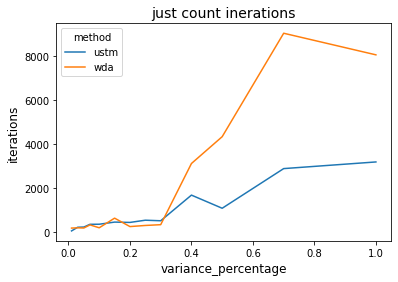

In [47]:
for method in ['ustm', 'wda']:
    plt.plot(variance_list, result[method], label = method)
plt.legend(title = 'method')
plt.title("just count inerations", fontsize = 14)
plt.xlabel("variance_percentage", fontsize = 12)
plt.ylabel("iterations", fontsize = 12)
plt.savefig('count_iteration_for_variance.png', dpi=300)
plt.show()

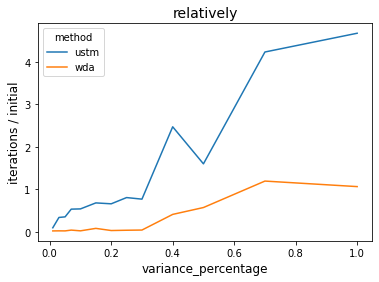

In [48]:
for method in ['ustm', 'wda']:
    plt.plot(variance_list, np.array(result[method]) / result_initial[method], label = method)
plt.legend(title = 'method')
plt.title("relatively", fontsize = 14)
plt.xlabel("variance_percentage", fontsize = 12)
plt.ylabel("iterations / initial", fontsize = 12)
plt.savefig('relatively_iteration_for_variance.png', dpi=300)
plt.show()

In [ ]:
для двух методов на одном графе 
при замене графа заново считать инитиал с тайм фри флоу
для ноды (20 нод) считаем разные 5 семплов
нарисовать линию красную
для каждого эксперимента надо брать расстояние от нового оптимума и фри флоу и расстояние от 